In [1]:
import pandas as pd
from cleaning import create_demand
import pyomo.environ as pyo
import pyomo

# Data import

In [2]:
nodes = pd.read_pickle("../../data/original/nodes.pkl")
channels = pd.read_pickle("../../data/original/channels.pkl")

## Modeling

In [3]:
pyomo.common.timing.report_timing()

In [4]:
# Multiplication to set the same base unit for all computations
channels["capacity"] = channels["capacity"] * 1000000
channels["base_fee"] = channels["base_fee"] * 1000000

In [5]:
model = pyo.ConcreteModel(name="Min cost flow problem")
model.NODES = pyo.Set(initialize=nodes.index)
model.CHANNELS = pyo.Set(initialize=[(channels.loc[i, "node1_pub"], channels.loc[i, "node2_pub"]) for i in channels.index])

           0 seconds to construct Block ConcreteModel; 1 index total
        0.02 seconds to construct Set NODES; 1 index total
        0.18 seconds to construct Set CHANNELS; 1 index total


In [6]:
transaction_amount = 100000
nodes = create_demand(nodes, transaction_amount,
                      source="02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3",destination="0202f00d5f5c91a3c79113851b162c2b75f2cbd9fb2378fb4a4ce92d5ba1e63e08")

Transaction of 100000 sats.
Sender: VeniceForever
Receiver: ShatSat412.


In [7]:
model.x = pyo.Var(model.CHANNELS, domain=pyo.Binary)
model.a = pyo.Var(model.CHANNELS, domain=pyo.NonNegativeReals, bounds=(0, max(nodes["demand"])))

        0.11 seconds to construct Var x; 89898 indices total
        0.13 seconds to construct Var a; 89898 indices total


In [8]:
channels.reset_index(inplace=True)
channels.set_index(["node1_pub", "node2_pub"], inplace=True)
channels.sort_index(inplace=True)

### Objective function

$$
min \sum_{} ^{} amount_i \times feerate_{i} + x_{i} \times basefee_{i}
$$

In [9]:
#def objective_function(model: pyo.ConcreteModel):
#    return sum(model.a[i] * channels.loc[i, "rate_fee"] for i in model.CHANNELS) + sum(model.x[i] * channels.loc[i, "base_fee"] for i in model.CHANNELS)

def objective_function(model: pyo.ConcreteModel):
    return sum(model.a[i] * channels.loc[i, "rate_fee"] + model.x[i] * channels.loc[i, "base_fee"] for i in model.CHANNELS)

model.totalCost = pyo.Objective(rule=objective_function(model), sense=pyo.minimize)

           0 seconds to construct Objective totalCost; 1 index total


### Constraints

#### Symmetric channel flow rule

This constraint enforces the symmetry between the number of channel incoming and outgoing from an intermediary node (excluding source and destination nodes)

$$
\sum_{(i,n) \in E} x_{i,n} = \sum_{(n,j) \in E} x_{n,j} \text{ } \forall n \in V \bigwedge i \ne \{n, s, d\}
$$

where $s$ is the source node, with a negative demand and $d$ is the destination node, with positive demand.

In [10]:
s = nodes[nodes["demand"] < 0].index.values
d = nodes[nodes["demand"] > 0].index.values
intermediaries = [(i, j) for i, j in channels.index if i != s and j != d]

In [11]:
def number_channels_rule(model: pyo.ConcreteModel, n):
    incoming = [model.x[(i, j)] for i, j in intermediaries if j == n]
    outgoing = [model.x[(i, j)] for i, j in intermediaries if i == n]
    return sum(incoming) == sum(outgoing)

model.NumberChannelsConstraint = pyo.Constraint(model.NODES, rule=number_channels_rule, name="Number channels constraint")

       52.21 seconds to construct Constraint NumberChannelsConstraint; 11984 indices total


#### Capacity constraint

$$amount_{i,j} \le capacity_{i,j} \times x_{i,j} \text{ } \forall (i,j) \in E$$

In [12]:
def capacity_constraint(model: pyo.ConcreteModel, a, b):
    return model.a[(a, b)] <= channels.loc[(a, b), "capacity"] * model.x[(a, b)]

model.CapacityConstraint = pyo.Constraint(model.CHANNELS, rule=capacity_constraint, name="Capacity constraint")

        4.94 seconds to construct Constraint CapacityConstraint; 89898 indices total


#### Flow balance constraint

$$\sum_{(s,i) \in E} amount_{s,i} - \sum_{(i,t) \in E} amount_{i,d} = b_i \text{ } \forall i \in V$$

where $s$ is the source node, $d$ is the destination node, $i$ is every intermediary node


In [13]:
channels.reset_index(inplace=True)
channels.set_index("channel_id", inplace=True)

def flow_balance_constraint(model: pyo.ConcreteModel, n: str):
    InFlow = sum(model.a[(channels.loc[a, "node1_pub"], channels.loc[a, "node2_pub"])] for a in nodes.loc[n, 'incoming_channels'])
    OutFlow = sum(model.a[(channels.loc[a, "node1_pub"], channels.loc[a, "node2_pub"])] for a in nodes.loc[n, 'outgoing_channels'])
    return  OutFlow + nodes.loc[n, "demand"] == InFlow

model.FlowBalanceConstraint = pyo.Constraint(model.NODES, rule=flow_balance_constraint, name="Flow balance constrain")

channels.reset_index(inplace=True)
channels.set_index(["node1_pub", "node2_pub"], inplace=True)
channels.sort_index(inplace=True) 

        3.25 seconds to construct Constraint FlowBalanceConstraint; 11984 indices total


## Solving the model

In [14]:
from pyomo.common.tempfiles import TempfileManager
TempfileManager.tempdir = "/home/filippo/repositories/LN-pathfinding"

In [15]:
opt = pyo.SolverFactory('cbc')
#opt = pyo.SolverFactory('cplex_direct')
results = opt.solve(model, tee=True, keepfiles=True)

if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    print('\nOptimal solution found')
elif results.solver.termination_condition == pyo.TerminationCondition.feasible:
    print('\nFeasible but not proven optimal solution found')
elif results.solver.termination_condition == pyo.TerminationCondition.infeasible:
    raise Exception("The model is infeasible")
else:
    print('\nSolver Status: ',  results.solver.status)
    raise Exception(results.solver.status)

print('\nObject function value = ', model.Objective())


           0 seconds to construct Var ONE_VAR_CONSTANT; 1 index total
      [    2.27] Generated LP representation
Solver log file: '/home/filippo/repositories/LN-pathfinding/tmp6u27n6ck.cbc.log'
Solver solution file: '/home/filippo/repositories/LN-pathfinding/tmpf7crzrb6.pyomo.soln'
Solver problem files: ('/home/filippo/repositories/LN-pathfinding/tmpf7crzrb6.pyomo.lp',)
Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  9 2022 

command line - /usr/bin/cbc -printingOptions all -import /home/filippo/repositories/LN-pathfinding/tmpf7crzrb6.pyomo.lp -stat=1 -solve -solu /home/filippo/repositories/LN-pathfinding/tmpf7crzrb6.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 95149 (-18717) rows, 166362 (-13434) columns and 476850 (-61370) elements
Statistics for presolved model
Original problem has 89898 integers (89898 of which binary)
Presolved problem has 83179 integers (83179 of which binary)
==== 38051 zero objective 3917 dif

In [16]:
#from pyomo.opt import SolverStatus, TerminationCondition

print("Solver Status: ",  results.solver[0]["System time"])


Solver Status:  36.62


In [17]:
from decimal import Decimal
pd.set_option('display.max_colwidth', 10000000000000000000000000000000000000000000000000000)
DF_channels = pd.DataFrame()
c = 0
for index, value in model.a.extract_values().items():
    if value > 0.1:
        DF_channels.loc[c, "source"] = index[0]
        DF_channels.loc[c, "destination"] = index[1]
        try:
            DF_channels.loc[c, "source-alias"] = nodes.loc[index[0], "alias"]
        except KeyError:
            print("Source alias not found in nodes database: placeholder inserted")
            DF_channels.loc[c, "source-alias"] = "source-alias"
            pass
        try:
            DF_channels.loc[c, "destination-alias"] = nodes.loc[index[1], "alias"]
        except KeyError:
            print("Destination alias not found in nodes database: placeholder inserted")
            DF_channels.loc[c, "destination-alias"] = "destination-alias"
            pass
        DF_channels.loc[c, "capacity"] = Decimal(channels.loc[index, "capacity"]/1000000)
        DF_channels.loc[c, "amount"] = Decimal(value/1000000)
        DF_channels.loc[c, "base_fee"] = Decimal(channels.loc[(index[0], index[1]), "base_fee"]/1000000)
        DF_channels.loc[c, "rate_fee"] = channels.loc[(index[0], index[1]), "rate_fee"]
        #DF_channels.loc[c, "used_fl"] = channels.loc[]
        c += 1

DF_channels_pos = DF_channels[DF_channels["amount"]!=0]

In [18]:
DF_channels[DF_channels["amount"]> DF_channels["capacity"]]

,source,destination,source-alias,destination-alias,capacity,amount,base_fee,rate_fee


In [19]:
DF_fixed = pd.DataFrame()
c = 0
for index, value in model.x.extract_values().items():
    if value != 0:
        DF_fixed.loc[c, "source"] = index[0]
        DF_fixed.loc[c, "destination"] = index[1]
        DF_fixed.loc[c, "used"] = Decimal(value)
        c += 1

DF_fixed_pos = DF_fixed[DF_fixed["used"]!=0]
DF_fixed_pos

,source,destination,used
0,02001828ca7eb8e44d4d78b5c1ea609cd3744be823c22cd69d895eff2f9345892d,030b252eb8bb0f5e79af393d26dd5204f3c525af8b84043c4f5fcd7c9482c15a23,1
1,0204edf87f5ee7d4e29a43756c87ff4f3152f3ea5de34867df6a665a3920b37e21,02473eb084d0410351e343547c68dac1961d1c8e18d0da3c1e4888d113d8f8eab8,1
2,02055838411dba34c72329e9872fc66d2f0dc0292c049d1313122cdec12c8d5883,0337d0c749f89d24e75427e1fec4ce2ed4f7d5a38c2196bc69825aa9e439696ec4,1
3,02062a64c5d381c77f8ef679133e6207b995d33914c97c072f854eda8ef4e6ea78,03bbdf5faaa9cb0ef87fca90fe31df13b9ca6203c264558e006a1c764ac1ea6874,1
4,0207271bbe0a744d5ec18e3aecd54904feb5e498c2fa65e4802b7710f26b61daa2,02315fe3619ffdea2561bcacecada87b226723f471a59fdbfec18c4e84bcf785b2,1
...,...,...,...
1394,03fd8cc2d81e7f52c05b799372c2dc16120fe1723f3d8dbd26bca8ab26bbddffad,02315fe3619ffdea2561bcacecada87b226723f471a59fdbfec18c4e84bcf785b2,1
1395,03fe824c5b3a0fb78e7f2844bfd052c8fe729b48ce1ffb15ce7aeef9a63e5ee761,030b252eb8bb0f5e79af393d26dd5204f3c525af8b84043c4f5fcd7c9482c15a23,1
1396,03fee917a3c0636f95d2529985a57ed185da42f35413f86a9e5d2d109100f15bd1,03cde60a6323f7122d5178255766e38114b4722ede08f7c9e0c5df9b912cc201d6,1
1397,03ff3e6c4078f9bad09f27100366b1e226f55331a3a66fb30201a7ddbac2b63bfd,03c4b52dab7fe8ea9be955f16c8bb0c763c3eb2cbe12867a24dd3f4378d5c0fb92,1


### All data about channels on path

In [20]:
intersection = DF_fixed_pos.merge(DF_channels_pos, on=["source", "destination"], how="outer")
final = intersection[intersection["amount"]>0]
final

,source,destination,used,source-alias,destination-alias,capacity,amount,base_fee,rate_fee
640,02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3,038dea9341a1be887457b117ef70e8a4a87ca03163e0cda3f1e2254e2a7590d3ac,1,VeniceForever,tantundem,500000,100000,0.001000000000000000020816681711721685132943093776702880859375,0.00000
768,02f0c7b731ca40a285d7c12aa1c5c7c7caa4598d3d6d34904c3714cd0d47852640,033b63e4a9931dc151037acbce12f4f8968c86f5655cf102bbfa85a26bd4adc6d9,1,Henwen 🐷,Garlic🧄,15000000,100000,0,0.00000
800,02f49ea881d143aa97a8ab464d1fcbe8da54d2b226c87cfab40a674e656a5149bd,035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8cbc711002ba215bfc226,1,sol-system,WalletOfSatoshi.com,5000000,100000,0,0.00001
991,033b63e4a9931dc151037acbce12f4f8968c86f5655cf102bbfa85a26bd4adc6d9,03c8e5f583585cac1de2b7503a6ccd3c12ba477cfd139cd4905be504c2f48e86bd,1,Garlic🧄,Strike,25000000,100000,0,0.00000
1049,035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8cbc711002ba215bfc226,02f0c7b731ca40a285d7c12aa1c5c7c7caa4598d3d6d34904c3714cd0d47852640,1,WalletOfSatoshi.com,Henwen 🐷,15000000,100000,0,0.00000
1134,038dea9341a1be887457b117ef70e8a4a87ca03163e0cda3f1e2254e2a7590d3ac,02f49ea881d143aa97a8ab464d1fcbe8da54d2b226c87cfab40a674e656a5149bd,1,tantundem,sol-system,500000,100000,0,0.00000
1303,03c8e5f583585cac1de2b7503a6ccd3c12ba477cfd139cd4905be504c2f48e86bd,0202f00d5f5c91a3c79113851b162c2b75f2cbd9fb2378fb4a4ce92d5ba1e63e08,1,Strike,ShatSat412,10000000,100000,1,0.00010


In [21]:
%%capture --no-stdout
final["amount"] = final["amount"].astype(float)
final["rate_fee"] = final["rate_fee"].astype(float)
final["base_fee"] = final["base_fee"].astype(float)
total_transaction_cost = sum(final["amount"] * final["rate_fee"] + final["base_fee"])
perc_cost = (total_transaction_cost * 100) / transaction_amount
print(f"Transacting {transaction_amount} sats costs {total_transaction_cost} ({perc_cost}% of transaction amount)")

Transacting 100000 sats costs 12.001 (0.012001% of transaction amount)


/home/filippo/repositories/LN-pathfinding/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128055 (\N{PIG FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/filippo/repositories/LN-pathfinding/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129476 (\N{GARLIC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


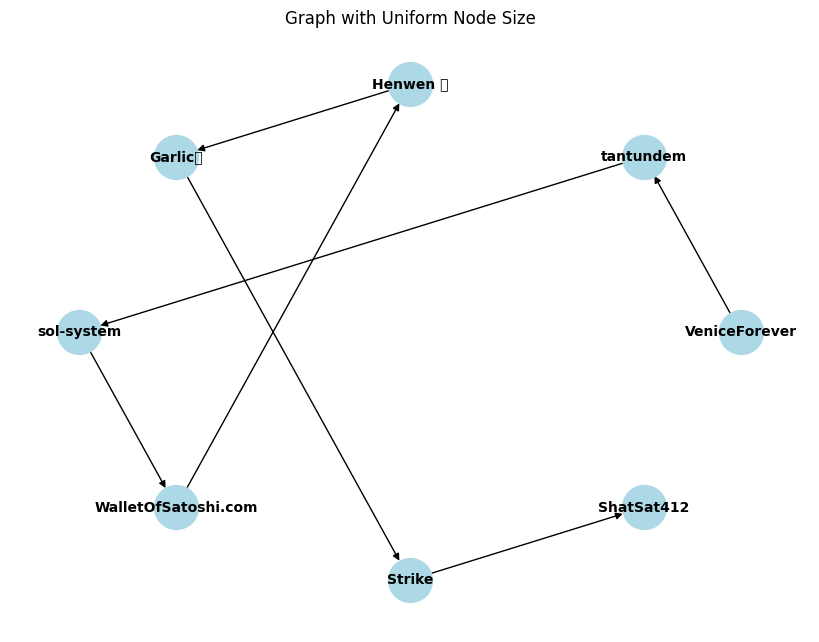

In [22]:

import networkx as nx
import matplotlib.pyplot as plt

# edges list construction
edges_df = final[["source-alias", "destination-alias"]]

G = nx.from_pandas_edgelist(edges_df, "source-alias", "destination-alias", create_using=nx.DiGraph())

plt.figure(figsize=(8, 6))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=10, font_color='black', font_weight='bold', arrows=True)
plt.title("Graph with Uniform Node Size")
plt.show()


In [23]:
#from collections import Counter
#results = [tuple(i) for i in DF_channels_pos[["source-alias", "destination-alias"]].to_numpy()]
#unwrap = [e for i in results for e in i]
#extremes = [j for j in unwrap if Counter(unwrap)[j] == 1]
#def return_source(l: list):
#    if l[0] in [i for i, j in results]:
#        return l[0]
#    else: 
#        return l[1]
#sequence = []        
#source = return_source(extremes)
#sequence.append(source)
#while len(sequence) <= len(results):
#    for i,j in results:
#        if i == sequence[-1]:
#            sequence.append(j)
#for i in sequence:
#    print("⬇️", i)